## Hybrid coupled FEM/BEM solver for the Poisson-Boltzman equation

We consider domain $\Omega$ divided into a molecular region $\Omega_m$ and a the solvent region $\Omega_s$ with common boundary $\Gamma$. We want to solve the Poisson-Boltzman problem
$$
- \nabla \cdot \left(\epsilon \nabla \widehat{u}(x)\right) + \widehat{\kappa}^2 \sinh\left(\widehat{u}(x)\right)  =   \sum_{i=1}^N Q_i \delta(x-P_i) \mbox{ in }  \Omega 
$$
where
\begin{align*}
\epsilon := \left\{
        \begin{array}{lr}
           \epsilon_m & \mbox{in }  \Omega_m \\
           \epsilon_s & \mbox{in }  \Omega_s
        \end{array}
    \right. 
    &, \quad \mbox{and}&
\widehat{\kappa} := \left\{
        \begin{array}{lr}
           0 & \mbox{in }  \Omega_m \\
           \sqrt{\epsilon_s} \kappa & \mbox{in }  \Omega_s
        \end{array}.
    \right.  
\end{align*}
<!-- We use the 3 term splitting approch, introduced in I.-L. Chern, J.-G. Liu and W.-C. Wan, \textit{Accurate evaluation of electrostatics for macromolecules in solution}, Methods Appl. Anal., 10 (2003), 309–328,
$$
\widehat{u} := u + \frac{\epsilon-\epsilon_s}{\epsilon_m-\epsilon_s}\left(u_c+u_h\right).
$$
The component $u_c$ is the singular component given by the charges in the molecular region. Another component $u_h$ is the harmonic extension of the trace of the singular component $u_c$ on the molecular surface into the interior of the molecule. It is completely determined by the singular component $u_s$ and the geometry of the molecular surface through the harmonic equation
$$
\left\{
        \begin{array}{rcll}
            - \Delta u_h & = & 0 & \mbox{in }  \Omega_m \\
             u_h & = & -u_c & \mbox{on }  \Gamma 
        \end{array}
    \right.
$$ -->

We can reformulate our problem as follows
$$
\left\{
        \begin{array}{rcll}
            - \nabla \cdot \left(\varepsilon \nabla u \right) + \widehat{\kappa}^2 \sinh u& = & \sum_{i=1}^N Q_i \delta(x-P_i) & \mbox{in }  \Omega \\
             [u] & = & 0 & \mbox{on }  \Gamma \\
             [\epsilon  \partial_n u] & = & 0 & \mbox{on }  \Gamma %\\
%              |u| & \rightarrow & 0 & \mbox{while } |x| \rightarrow \infty
        \end{array}
    \right.
$$
where $n$ is an outward normal vector to $\Gamma$.

The discrete interior problem for known $\widetilde{u}$ is given as
\begin{align*}
 \frac{\epsilon_m}{\epsilon_s}\int_{\Omega_m} \nabla u : \nabla v_h dx -  \frac{\epsilon_m}{\epsilon_s} \left< \partial_n u, \ v_h\right>_{\Gamma } 
  & \\
 -  \frac{\epsilon_m}{\epsilon_s} \left< u, \ \partial_n v_h \right>_{\Gamma} 
  + \tfrac{\tau_F}{h} \left< u,\ v_h \right>_{\Gamma} & =  \sum_{i=1}^N Q_i \delta(x-P_i).
\end{align*}
We are using FEniCS finite element library, hence the above formulation is more sumilar to the implementation.

However for exterior problem we use matrix form, for clarity and similarity with BEMpp implementation. In this case we consider linearised formulation of the Poisson-Boltzman equation that means our operators are built as for modified Helmholtz equation with wavenumber $\kappa$.
For given $\widetilde{u}$, the discrete exterior problem is given as
\begin{align*}
V \lambda  - \left( \tfrac{1}{2}Id + K \right) u &= - \widetilde{u},  \\
 \left( \tfrac{1}{2} Id +  K'\right)  \lambda + \left(W + \tau_B Id\right)  u  &= \tau_B  \widetilde{u}.
\end{align*}
Both, the interior and exterior problems have unique solutions for given $\widetilde{u}$. In order to find $\widetilde{u}$ we solve the following problem on $\Gamma$
$$
\tau_B \left( u_s - \widetilde{u}\right) + \tfrac{\tau_F}{h} \left( u_m - \widetilde{u}\right) - \left(\frac{\epsilon_m}{\epsilon_s} \partial_n u -\lambda\right)  = 0.
$$

## Implementation of the exterior solver

We first implement a solver class for the exterior formulation.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import bempp.api
import numpy as np

from scipy.sparse.linalg import LinearOperator
from bempp.api.assembly.discrete_boundary_operator import InverseSparseDiscreteBoundaryOperator
from bempp.api.assembly.blocked_operator import BlockedDiscreteOperator


class InverseOperator(LinearOperator):
    """Implement the LU inverse as linear operator."""
    
    def __init__(self, mat):
        """Initialise with Numpy array to invert."""
        from scipy.linalg import lu_factor
        
        self._factor = lu_factor(mat)
        super().__init__(mat.dtype, mat.shape)
        
    def _matmat(self, arr):
        """Apply the inverse"""
        from scipy.linalg import lu_solve
        
        return lu_solve(self._factor, arr)

class ExteriorHybrid(LinearOperator):
    """
    Implement an hybrid solver for exterior Poisson-Boltzmann problem.
    
    """
    
    def __init__(self, space, beta, epsilon,  wavenumber, precond, solv):
        """Instantiate the exterior solver."""
        
        self._beta = beta
        self._epsilon = epsilon
        self._space = space
        self._wavenumber = wavenumber
        self._precond = precond
        self._solv = solv
    
        self._assemble_operator()
        
        super().__init__(np.float64, 
                         (space.global_dof_count, space.global_dof_count)
                        )
    def _assemble_operator(self):                
        """Assemble the operators."""
        from scipy.linalg import block_diag
        
        ident = bempp.api.operators.boundary.sparse.identity(
                                self._space, self._space, self._space)
        self._invmass = InverseSparseDiscreteBoundaryOperator(ident.weak_form()) #bempp.api.InverseSparseDiscreteBoundaryOperator(ident.weak_form()).T@
        
        if fmm:
            if self._wavenumber == 0:
                dlp = bempp.api.operators.boundary.laplace.double_layer(
                                    self._space, self._space, self._space, assembler="fmm")
                slp = bempp.api.operators.boundary.laplace.single_layer(
                                    self._space, self._space, self._space, assembler="fmm")
                adlp = bempp.api.operators.boundary.laplace.adjoint_double_layer(
                                    self._space, self._space, self._space, assembler="fmm")
                hslp = bempp.api.operators.boundary.laplace.hypersingular(
                                    self._space, self._space, self._space, assembler="fmm")
            else:
                dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(
                                    self._space, self._space, self._space, self._wavenumber, assembler="fmm")
                slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(
                                    self._space, self._space, self._space, self._wavenumber, assembler="fmm")
                adlp = bempp.api.operators.boundary.modified_helmholtz.adjoint_double_layer(
                                    self._space, self._space, self._space, self._wavenumber, assembler="fmm")
                hslp = bempp.api.operators.boundary.modified_helmholtz.hypersingular(
                                    self._space, self._space, self._space, self._wavenumber, assembler="fmm")
        else:
            if self._wavenumber == 0:
                dlp = bempp.api.operators.boundary.laplace.double_layer(
                                    self._space, self._space, self._space)
                slp = bempp.api.operators.boundary.laplace.single_layer(
                                    self._space, self._space, self._space)
                adlp = bempp.api.operators.boundary.laplace.adjoint_double_layer(
                                    self._space, self._space, self._space)
                hslp = bempp.api.operators.boundary.laplace.hypersingular(
                                    self._space, self._space, self._space)
            else:
                dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(
                                    self._space, self._space, self._space, self._wavenumber)
                slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(
                                    self._space, self._space, self._space, self._wavenumber)
                adlp = bempp.api.operators.boundary.modified_helmholtz.adjoint_double_layer(
                                    self._space, self._space, self._space, self._wavenumber)
                hslp = bempp.api.operators.boundary.modified_helmholtz.hypersingular(
                                    self._space, self._space, self._space, self._wavenumber)
                

        self._ident = ident.weak_form().A     
        
        
        blocks = [[None,None],[None,None]]
        blocks[0][0] = -(0.5 * ident + dlp).weak_form()
        blocks[0][1] =  slp.weak_form()

        blocks[1][0] =  (self._beta * ident + hslp).weak_form()  
        blocks[1][1] =  (0.5 * ident + adlp).weak_form()
        
        self._prec_matrixBEM = BlockedDiscreteOperator(np.array(blocks))
            
    def _matvec(self, arr):
        
        sol = self.solve(arr,self._solv)
        return self._ident @ sol[self._space.global_dof_count:] + self._beta * self._ident @ sol[:self._space.global_dof_count]
    
    def solve(self, arr, iter_solv):
        """Solve the exterior problem."""
        
        rhs = np.concatenate([-(self._ident @ arr), self._beta * self._ident @ arr])
        
        if iter_solv == 1 and self._precond == 1:
            ########################## Preconditioner
            def apply_mass(x):
                """Apply the block diagonal preconditioner"""
                m1 = self._invmass.shape[0]
                m2 = self._invmass.shape[0]
                n1 = self._invmass.shape[1]
                n2 = self._invmass.shape[1]

                res1 = self._invmass.dot(x[:n1])
                res2 = self._invmass.dot(x[n1:n1+n2]) #
                return np.concatenate([res1, res2])

            mass_shape = (2*self._invmass.shape[0], 2*self._invmass.shape[1])
            Mass = LinearOperator(mass_shape, apply_mass, dtype=np.dtype('float64'))
             
            prec_solBEM, _info = gmres(self._prec_matrixBEM , rhs, M = Mass, tol = tol, restrt=500)
            return prec_solBEM 
        elif  iter_solv == 1 and self._precond == 0:
            prec_solBEM, _info = gmres(self._prec_matrixBEM , rhs, M = None, tol = tol)
            return prec_solBEM 
        else:
            lhs = InverseOperator(self._prec_matrixBEM.A)
            return lhs @ rhs
        

    def solution(self, arr, coeff, iter_solv):
        """Calculate the solution of the interior problem. """
        id_op = bempp.api.operators.boundary.sparse.identity(
                            self._space, self._space, self._space)
        if fmm:
            if self._wavenumber == 0:        
                dlp = bempp.api.operators.boundary.laplace.double_layer(
                                    self._space, self._space, self._space, assembler="fmm")
                slp = bempp.api.operators.boundary.laplace.single_layer(
                                    self._space, self._space, self._space, assembler="fmm")
            else:
                dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(
                                    self._space, self._space, self._space, self._wavenumber, assembler="fmm")
                slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(
                                    self._space, self._space, self._space, self._wavenumber, assembler="fmm")
        else:
            if self._wavenumber == 0:        
                dlp = bempp.api.operators.boundary.laplace.double_layer(
                                    self._space, self._space, self._space)
                slp = bempp.api.operators.boundary.laplace.single_layer(
                                    self._space, self._space, self._space)
            else:
                dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(
                                    self._space, self._space, self._space, self._wavenumber)
                slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(
                                    self._space, self._space, self._space, self._wavenumber)
            
        rhs = (((dlp-0.5*id_op).weak_form().A) @ arr).T
        
        if iter_solv == 1:
            prec_solBEM, _info = gmres(coeff*slp.weak_form().A, rhs, M = self._invmass, tol = tol)
            return prec_solBEM 
        else:
            lhs = InverseOperator(coeff*slp.weak_form().A)
            return lhs @ rhs

## Implementation of the interior solver

For the interior formulation we use the FEniCS finite element library.

In [2]:
class InteriorHybrid(LinearOperator):
    """Implement the FeniCS interior solver"""
    
    def __init__(self, fenics_space, epsilon, epsilon_s, beta, nor, trace_matrix, PC, Q, precond, solv):
        """Initialise the interior solver."""
        
        self._fenics_space = fenics_space
        self._epsilon = epsilon
        self._epsilon_s = epsilon_s
        self._beta = beta
        self._nor = nor
        self._trace_matrix = trace_matrix
        self._points = PC
        self._charges = Q
        self._precond = precond
        self._solv = solv
        
        self._assemble_operator()
        
        super().__init__(np.float64, (trace_matrix.shape[0], trace_matrix.shape[0]))
        
    def _assemble_operator(self):
        """Assemble the operators."""
        from bempp.api.external.fenics import FenicsOperator
        
        
        u = dolfin.TrialFunction(self._fenics_space)
        v = dolfin.TestFunction(self._fenics_space)
        
        self._stiffness = dolfin.assemble(self._epsilon/self._epsilon_s*(dolfin.dot(dolfin.grad(u),dolfin.grad(v))) * dolfin.dx() \
                            - self._epsilon/self._epsilon_s*dolfin.dot(dolfin.grad(v),self._nor)*u*dolfin.ds \
                            - self._epsilon/self._epsilon_s*dolfin.dot(dolfin.grad(u),self._nor)*v*dolfin.ds \
                            + self._epsilon/self._epsilon_s*self._beta*v*u*dolfin.ds() )
    
        self._B =  FenicsOperator(self._epsilon/self._epsilon_s*dolfin.dot(dolfin.grad(u),self._nor)*v*dolfin.ds() 
                        - self._epsilon/self._epsilon_s*self._beta*v*u*dolfin.ds()).weak_form().A
        self._BT = dolfin.assemble(self._epsilon/self._epsilon_s*dolfin.dot(dolfin.grad(v),self._nor)*u*dolfin.ds() 
                        - self._epsilon/self._epsilon_s*self._beta*v*u*dolfin.ds())
                            
        rhs_f = dolfin.Constant(0.0)
        self._rhs_fem = dolfin.assemble(rhs_f*v*dolfin.dx) 
        
        for i in range(len(self._points)):
            delta = dolfin.PointSource(self._fenics_space, dolfin.Point(self._points[i]), self._charges[i]/self._epsilon_s) #
            delta.apply(self._rhs_fem)
        
        
        
    def _matvec(self, arr):
        """
        Implement the interior part of the Schur complement
        Takes coefficients in Bempp ordering and returns trace values in Bempp ordering.
        """
        coef = (trace_matrix.T @ arr)
        lhs = dolfin.Function(self._fenics_space)
        lhs.vector()[:] = np.ascontiguousarray((coef))
        coeffs = self._BT * lhs.vector() 
        return -trace_matrix * (self._B @ self.solve(coeffs,self._solv))
    
    def get_b(self):
        """Return rhs vector"""
        return -trace_matrix * (self._B @ self.solve(self._rhs_fem,self._solv)) 
    
    def solve(self, arr,iter_solv):
        """Solve the interior problem. """
        
        u = dolfin.Function(self._fenics_space)
        U = u.vector()
        if iter_solv == 1 and self._precond == 1:
            solver = dolfin.KrylovSolver("cg", "icc") # Use solvers and preconditioners avalable in FEniCS
            prm = solver.parameters
            prm['absolute_tolerance'] = tol
            prm['maximum_iterations'] = 5000
            solver.solve(self._stiffness, U, arr) 
        elif iter_solv == 1 and self._precond == 0:
            solver = dolfin.KrylovSolver("cg", "none") # Use solvers and preconditioners avalable in FEniCS
            prm = solver.parameters
            prm['absolute_tolerance'] = tol
            prm['maximum_iterations'] = 5000
            solver.solve(self._stiffness, U, arr) 
        else:
            dolfin.solve(self._stiffness, U, arr)
        return np.array(U)
    
    def solution(self, arr,iter_solv):
        """Calculate the solution of the interior problem. """
        
        coef = (trace_matrix.T * arr)
        lhs = dolfin.Function(self._fenics_space)
        lhs.vector()[:] = np.ascontiguousarray((coef))
        coeffs = self._rhs_fem  - self._BT * lhs.vector() 
        return self.solve(coeffs,iter_solv)

## Combined Solver

The following operator implements the overall coup

In [3]:
class CombinedOperator(LinearOperator):
    """The overall system operator."""
    
    def __init__(self, t_plus, t_minus, epsilon, beta_fem, beta_bem):
        """Initialise the operator."""
        
        self._t_plus = t_plus
        self._t_minus = t_minus
        self._epsilon = epsilon
        self._beta_fem = beta_fem
        self._beta_bem = beta_bem
        
        self._C =  ((self._beta_bem+self._epsilon*self._beta_fem)*bempp.api.operators.boundary.sparse.identity(
                                    trace_space, trace_space, trace_space).weak_form())
        
        super().__init__(np.float64, (t_plus.shape[0], t_plus.shape[0]) )
        
    def _matvec(self, arr):
        """Perform a matvec."""
        
        tilde_u = arr[:].ravel()
        
        return (self._t_minus @ tilde_u - self._t_plus @ tilde_u + self._C @ tilde_u)

We can now implement the overall solver. Once the problem is solved we have the trace variable. We now applied the interior and exterior solvers one more time to obtain from the correct values of the solution u.

In [4]:
import dolfin
from dolfin_utils import meshconvert
from bempp.api.external.fenics import FenicsOperator
import numpy as np
from bempp.api.external import fenics
from scipy.sparse.linalg import cgs, minres, gmres
import pylab as plt
import time
from scipy.sparse import diags
 
tau = 5.
 
# Solver data #
tol = 1e-06         # Tolerance
fmm = 0             # Use FMM
precond = 1         # Use preconditioner for internal iterations
iter_solv = 1       # Use iteratice solver for 

# Problem data #
Q = np.array([1.0,1.0,0.75])                           # Charges
PC=np.array([[1,0,0],[0.7,0.7,0],[-0.5,-0.5,0]])       # Points of charges
R = np.array([2., 2., 2.])                             # Radiuses
w = 0.1250                                             # kappa
es = 80.                                               # External permitivity (solvant)
em = 4.                                                # Internal permitivity (molecule)

ec = 1.602176e-19 #[C]
kb = 1.380648e-23 #[J/K]
T  = 300 #[K]
S1 = 1 #(ec/(kb*T))  #38.681 [C/J]

# Result collecting lists #
solv_error = []
mesh_size = []
iter_num = []
time_solve = []

# Iteratotion for mesh #
grid_size = [0, 1, 2, 3, 4]

#Analytical solvation energy#
from an_solution import an_P
Rr = R[0]
G2 = an_P(Q, PC, em, es, Rr, w, Rr , 10)
print(G2)
    

-164.33752347454015


Solving problems for each of the mesh

In [5]:
for m in grid_size:
    ######################### Mesh and spaces ################################## 
    import os.path
    
    if not os.path.isfile("mesh_sphere_"+format(m)+".xml"):
        mesh_file = "Sphere_R_"+format(Rr)+"_h_2_"+format(m)+".msh"
        meshconvert.gmsh2xml(mesh_file, "mesh_sphere_"+format(m)+".xml", iformat=None)
        
    mesh = dolfin.Mesh("mesh_sphere_"+format(m)+".xml")  

    nor = dolfin.FacetNormal(mesh) 
    
    # Spaces for FEM and BEM #
    fenics_space = dolfin.FunctionSpace(mesh, "CG", 1)
    trace_space, trace_matrix = \
    fenics.fenics_to_bempp_trace_data(fenics_space)

    print("FEM dofs: {0}".format(mesh.num_vertices()))
    print("BEM dofs: {0}".format(trace_space.global_dof_count))
 
    mass = bempp.api.operators.boundary.sparse.identity(trace_space, trace_space, trace_space)
    
    # Stabilisation parameter #
    hmax = trace_space.grid.maximum_element_diameter
    mesh_size.append(hmax)
    beta_fem =  tau/hmax
    beta_bem =  1.
    
    ######################### Matrix and RHS ##################################
    # Solvant case
    start = time.time()     
    t_minus = InteriorHybrid(fenics_space, em, es, beta_fem, nor, trace_matrix, PC, Q, precond, iter_solv)
    t_plus  = ExteriorHybrid(trace_space, beta_bem, 1., w, precond, iter_solv)
    lhs = CombinedOperator(t_plus, t_minus, em/es, beta_fem, beta_bem)
    rhs =  t_minus.get_b()
    end = time.time()
    set_time = (end - start)     
    
    it_count = 0
    def count_iterations(x):
        global it_count
        it_count += 1
    
    ######################### SOLVERS ##################################
    # Solvant case
    start = time.time()     
    sol, _info = minres(lhs, rhs, M = None, tol = tol, callback=count_iterations)#, maxiter = 100) 1./(em/es*beta_fem+beta_bem)*t_plus._invmass
    end = time.time()
    curr_time = (end - start)
    
    iter_num.append(it_count)
    time_solve.append(curr_time)
    print("Number of iterations for solvant case: {0}".format(it_count))

    # Now compute the exterior to Dirichlet map #
    sol_bem = t_plus.solution(sol, em/es, iter_solv)
    u_plus = sol
    p_plus = sol_bem 

    dirichlet_fun = bempp.api.GridFunction(trace_space, coefficients=u_plus)
    neumann_fun = bempp.api.GridFunction(trace_space, coefficients=p_plus)
    
    ######################### Solvation energy ##################################
    
    slpF = bempp.api.operators.potential.laplace.single_layer(trace_space, np.transpose(PC)) 
    dlpF = bempp.api.operators.potential.laplace.double_layer(trace_space, np.transpose(PC))

    uF = slpF * neumann_fun - dlpF * dirichlet_fun

    q_uF = 0
    for i in range(len(PC)):
        Sum = (uF[0][i].real)*Q[i]
        q_uF = q_uF + Sum

    E_Solv = 0.5*4.*np.pi*332.064*(q_uF) 
    print('Energia de Solvatacion : {:7.3f} [kCal/mol]'.format(E_Solv))
    Error = np.abs( E_Solv/G2-1 )*100
    print('{:.4f}%'.format(Error))
    solv_error.append(Error)  

FEM dofs: 143
BEM dofs: 116


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of iterations for solvant case: 10
Energia de Solvatacion : -168.000 [kCal/mol]
2.2287%
FEM dofs: 457
BEM dofs: 316


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of iterations for solvant case: 11
Energia de Solvatacion : -165.814 [kCal/mol]
0.8984%
FEM dofs: 2303
BEM dofs: 1062


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of iterations for solvant case: 15
Energia de Solvatacion : -164.689 [kCal/mol]
0.2140%
FEM dofs: 15880
BEM dofs: 4184


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of iterations for solvant case: 17
Energia de Solvatacion : -164.424 [kCal/mol]
0.0525%
FEM dofs: 107586
BEM dofs: 15835


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of iterations for solvant case: 23
Energia de Solvatacion : -164.353 [kCal/mol]
0.0095%


The rest is plotting.

## Convergence plot

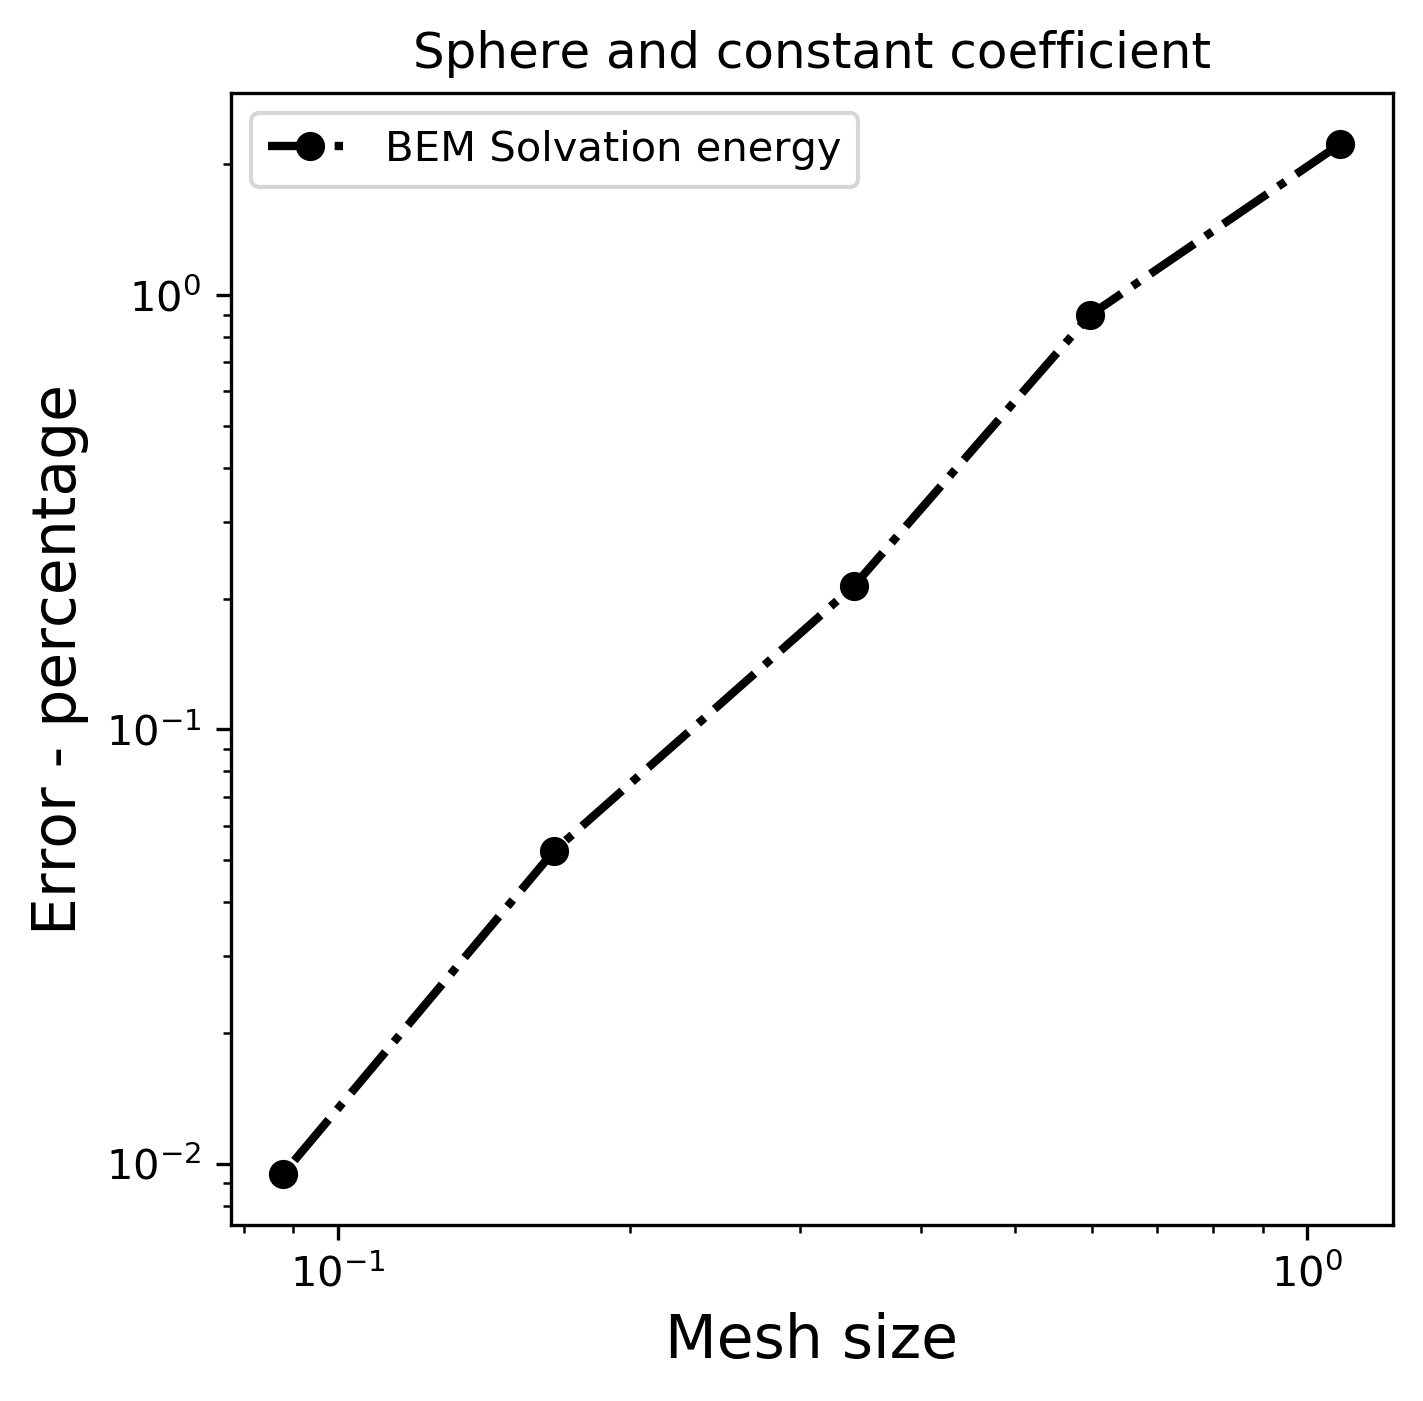

In [6]:
from operator import add
import matplotlib.pyplot as plt

with open('Hybrid_FEM_BEM_Sphere_Const_error.npy', 'wb') as f:
    np.save(f, np.array(solv_error))

plt.figure( figsize=(5, 5), dpi=300)
plt.loglog(mesh_size, solv_error, 'ko-.', linewidth=2, label='BEM Solvation energy')
# plt.loglog(mesh_size, o_mesh_size, 'k:', linewidth=1, label='O(h)')
plt.legend(loc='upper left')
plt.title('Sphere and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Error - percentage', fontsize='x-large')
plt.show()

## Iteration count

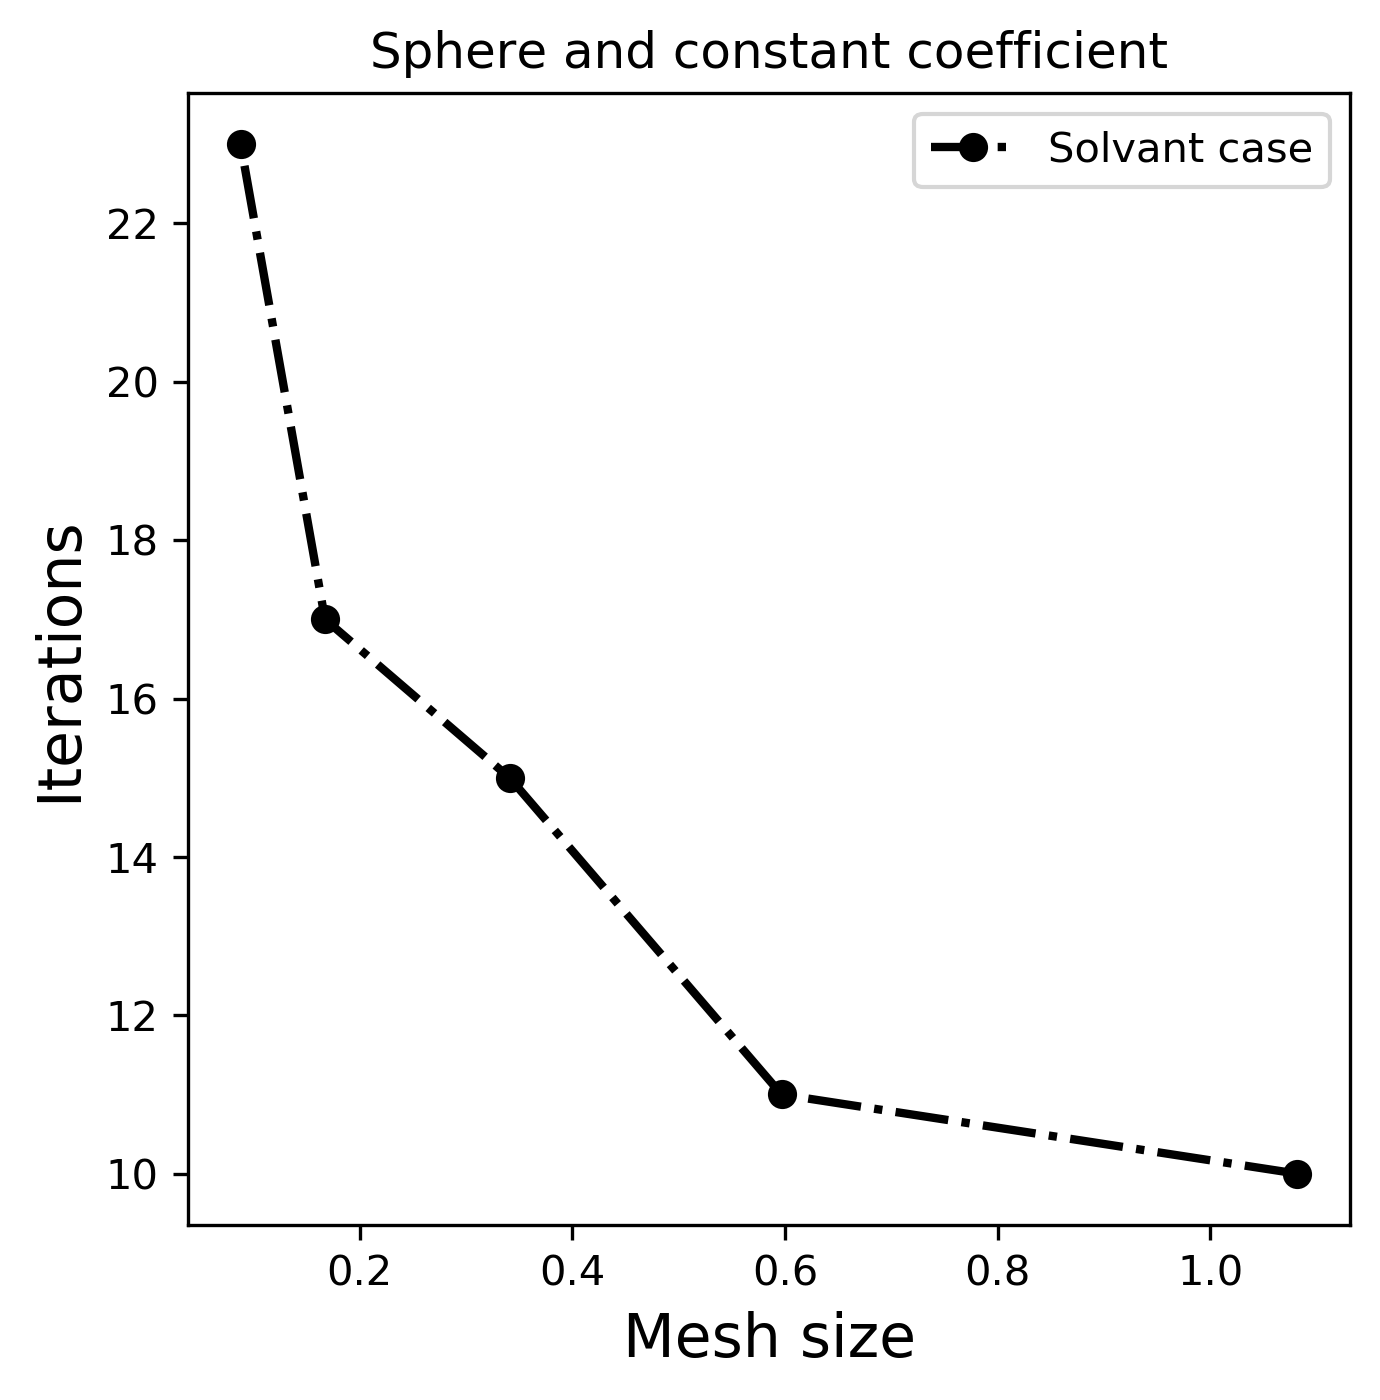

In [7]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

with open('Hybrid_FEM_BEM_Sphere_Const_iter.npy', 'wb') as f:
    np.save(f, np.array(iter_num))

plt.figure( figsize=(5, 5), dpi=300)
plt.plot(mesh_size, iter_num, 'ko-.', linewidth=2, label='Solvant case')
plt.legend(loc='upper right')
plt.title('Sphere and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Iterations', fontsize='x-large')
plt.show()

## Computational cost

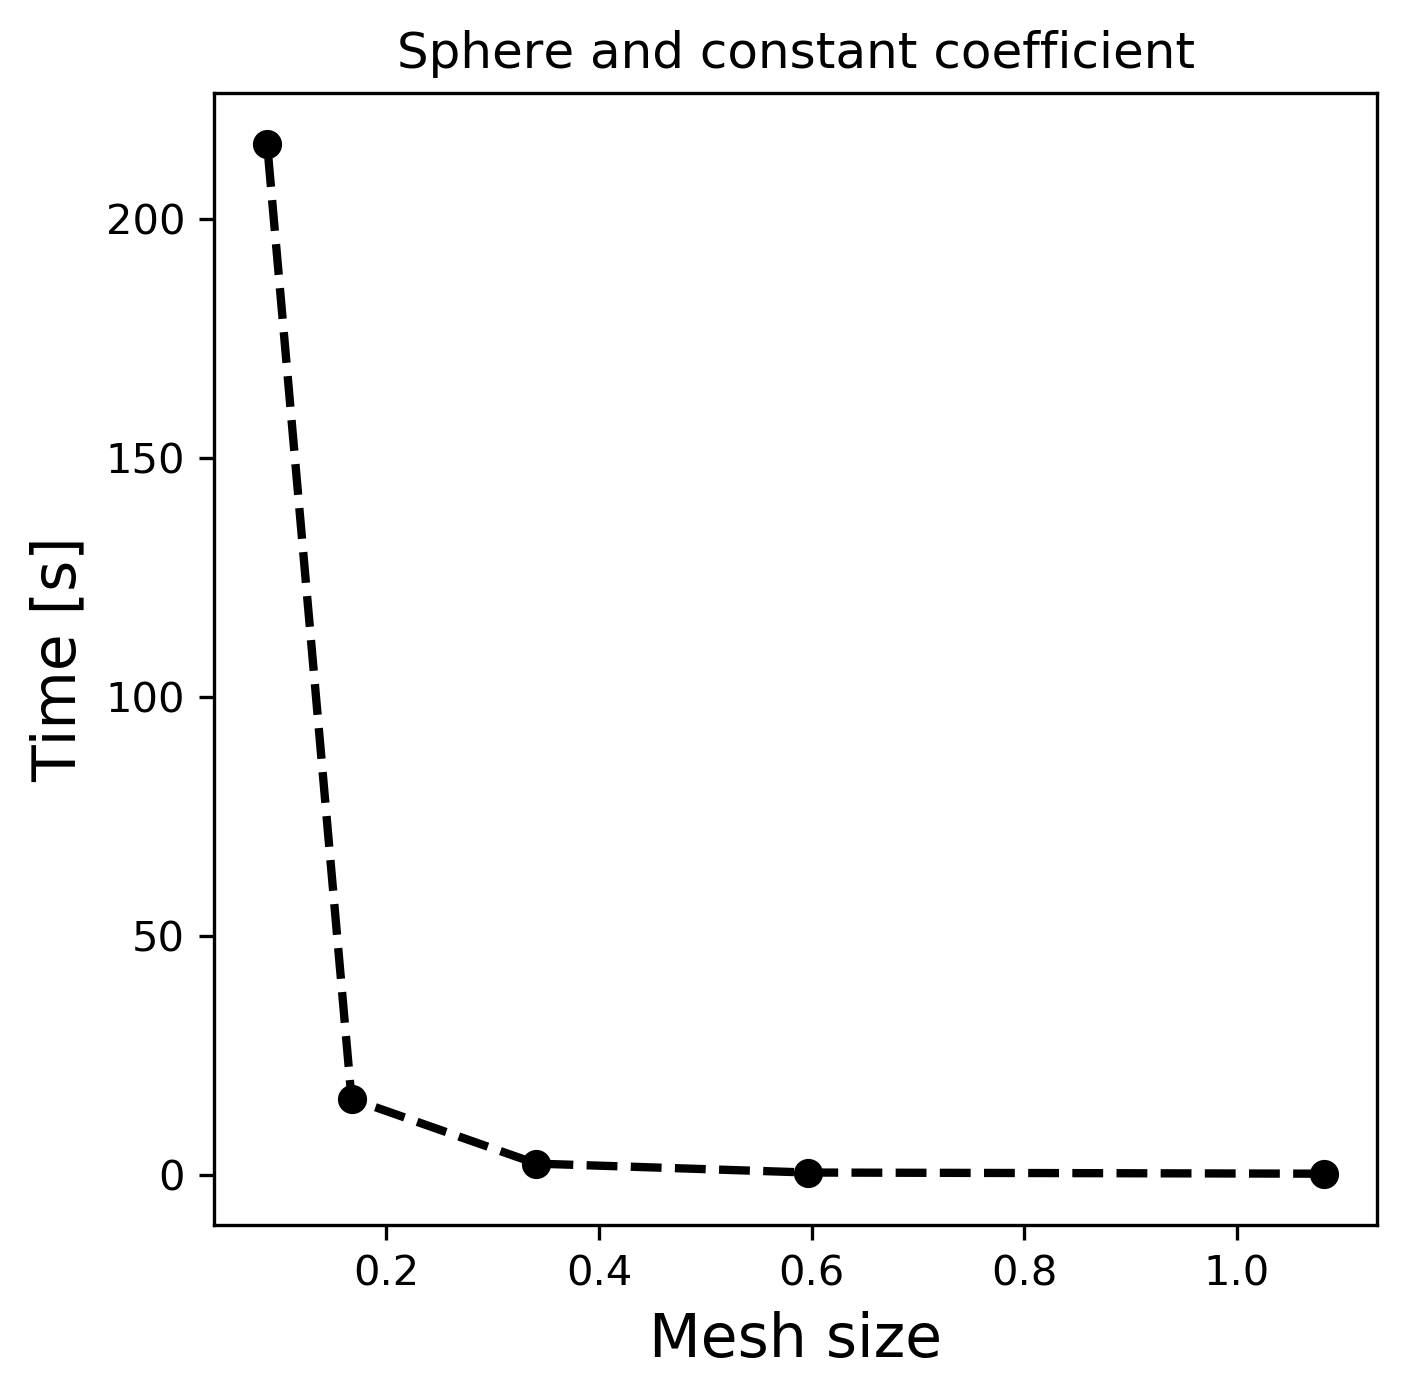

In [8]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

with open('Hybrid_FEM_BEM_Sphere_Const_time.npy', 'wb') as f:
    np.save(f, np.array(time_solve))

plt.figure( figsize=(5, 5), dpi=300)
plt.plot(mesh_size, time_solve, 'ko--', linewidth=2)
plt.title('Sphere and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Time [s]', fontsize='x-large')
plt.show()